In [227]:
from __future__ import annotations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Часть 1. Логрег своими руками (4.5 балла)

**Задание 1 (4 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью:
- градиентного спуска **(2 балла)**

- стохастического градиентного спуска **(2 балла)**

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавим атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

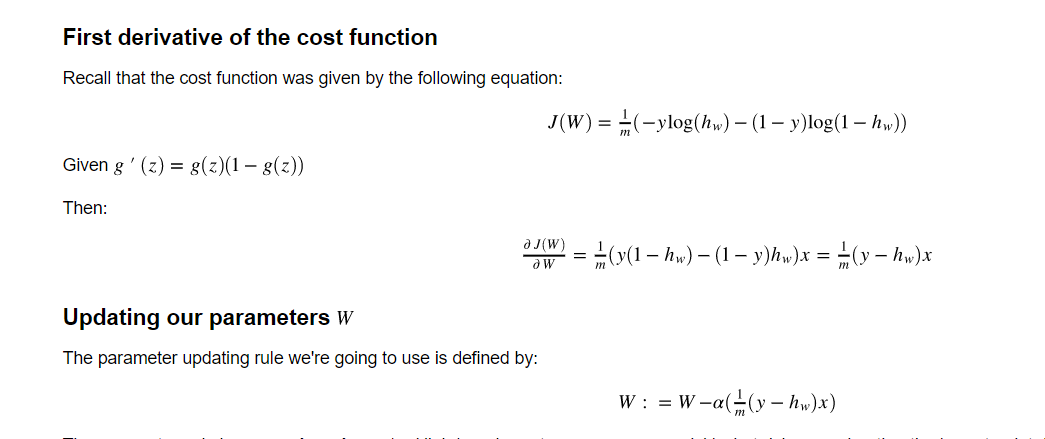

In [346]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-4, 
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Args:
          gd_type: Type of gradient descent ('full' or 'stochastic'). 
          
          tolerance: Threshold for stopping gradient descent.
          
          max_iter: Maximum number of steps in gradient descent.
          
          eta: Learning rate.
          
          w0: Array of shape d (d — number of weights to optimize).
              Initial weights.
        """
        self.gd_type = gd_type         #это тип (полный или стохастический) 
        self.tolerance = tolerance     #это проверка на евклидову норму разности весов на двух сосед итер  
        self.max_iter = max_iter      # это максим кол-во итераций град спуска 
        self.eta = eta                # скорость обучения 
        self.w0 = w0                   #массив весов 
        self.w = None                  #массив предсказанных классов 
        self.loss_history = None        #значения функции потерь для всех итераций градиентного спуска, начиная с нулевой

    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def fit(self, X: np.array, y: np.array) -> LogReg:
        """Fit the model on training data. Also, save value of loss after each iteration.
        Args:
          X: Training data.
          y: Target.
        Returns: 
          self: Fitted classsifier.  
        """
        self.loss_history = []
        self.w0 = np.zeros(X.shape[1])
        self.w=np.zeros(len(y))
        
        W=[]
        W.append(np.zeros(len(self.w0)))
       
        for i in range(self.max_iter):
            
            gradient = self.calc_gradient(X,y)
            
            self.w0 -= self.eta * gradient
            W.append(self.w0)
            
            #if i>1 and np.linalg.norm(W[i+1]-W[i])<self.tolerance:
                #print(W)
                #break
            
            e = self.calc_loss(X, y)
            self.loss_history.append(e) #сохраняем историю
            
        return self
    
    def predict_proba(self, X: np.array) -> np.array:
        """Calculate probability of positive and negative class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n, 2).
             Predicted probabilities.
        """
        
        if self.w is None:
            raise Exception('Not trained yet')
    
        return self.sigmoid(np.dot(X, self.w0)) 
           
    
    def predict(self, X: np.array) -> np.array:
        """Predict class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n,).
             Predicted class labels.  
             
        """
        self.w=self.predict_proba(X).round()
        if self.w is None:
            raise Exception('Not trained yet')
    
        return self.w
        
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Calculate gradient of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d), n can be equal to 1 if 'stochastic'.
          y: Array of shape (n,).
        
        Returns:
          Array of shape (d,).
          Gradient of loss function after current iteration.
        """
        if self.gd_type =='full':
            z = np.dot(X, self.w0)
            h = self.sigmoid(z)
            res=np.dot(X.T, (h - y)) / y.size
            
        if self.gd_type == 'stochastic':
            i = np.random.randint(0, len(y))
            Xi = X[i]
            yi = y[i]
            z = np.dot(Xi, self.w0)
            h = self.sigmoid(z)
            res=(Xi.T.dot((h - yi)))
            pass
        
        if self.gd_type not in ['stochastic','full']:
            raise Exception('Not correct type gradient decision')
            
        return res

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Calculate value of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d).
          y: Array of shape (n,).
        
        Returns:
          Value of loss function after current iteration.
        """ 
        z = np.dot(X, self.w0)
        h = self.sigmoid(z)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

Сгенерируем синтетические данные.

In [347]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2 (0.5 балла).** Обучите логистическую регрессию на синтетических данных. Нарисуйте изменение лосса во время обучения.

In [348]:
clf = LogReg(gd_type= 'full') 
clf.fit(X_train,y_train)
clf.predict(X_test[:2, :])
clf.predict_proba(X_test[:2, :])

array([0.59692963, 0.01196324])

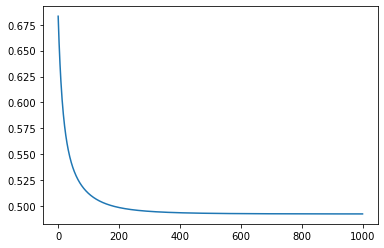

In [349]:
import matplotlib.pyplot as plt

it=[i for i in range(0,len(clf.loss_history))]
plt.plot(it, clf.loss_history)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

In [350]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test))

0.8457539657315984

In [351]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score, make_scorer

y_scores = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [352]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = \
        precision_recall_curve(y_true, y_score[:, 1])
    return auc(recall, precision, reorder=True)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)
pr_auc_scorer

make_scorer(pr_auc_score, needs_proba=True)

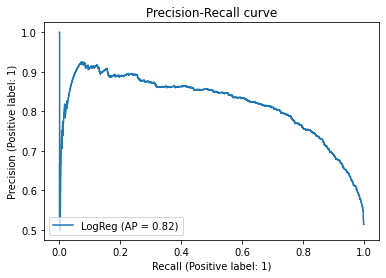

In [353]:
from sklearn.metrics import PrecisionRecallDisplay
y_score = clf.predict_proba(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LogReg")
_ = display.ax_.set_title("Precision-Recall curve")


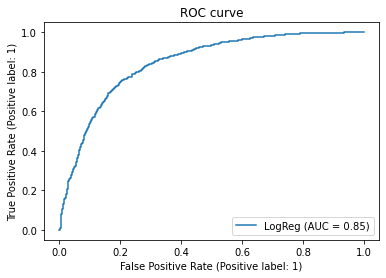

In [354]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

y_score = clf.predict_proba(X_test)
display= RocCurveDisplay.from_predictions(y_test, y_score,name="LogReg")
_ = display.ax_.set_title("ROC curve")